## Finally we integrate the results
The original paper uses a different error estimation approach (see SI in the paper), while here we use 5-fold block avegraing for the integrand. The statistics are quite comparable in both methods. While in the paper, the tool from https://github.com/ATB-UQ/trapz_errors/tree/master is used to propargate the uncertainties more rigorously considering the truncation error at each interval. In the notebook, the uncertainty propargation here in the notebook produces more optimistic using the following equation for a trapezoidal integration.

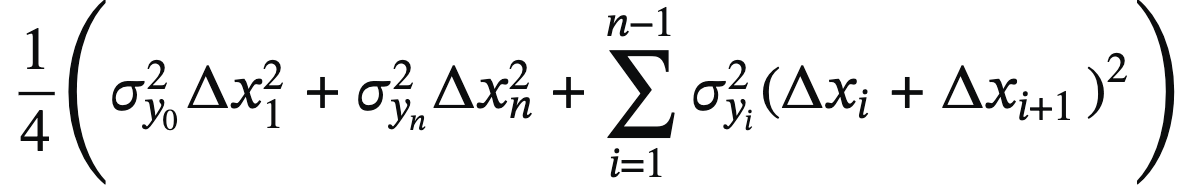

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as sc
import lammpsio
from collections import Counter


In [ ]:
mpl.rcParams['figure.dpi'] = 100

In [ ]:
def block_averaging(arr, num_blocks=5):
    n = len(arr)
    block_size = n // num_blocks
    
    means = []
    for i in range(num_blocks):
        start = i * block_size
        end = (i + 1) * block_size
        block = arr[start:end]
        means.append(np.mean(block))
    
    mean_of_means = np.mean(means)
    std_of_means = np.std(means)
    
    return mean_of_means, std_of_means


In [ ]:
'''
Free energies of crystals computed using Einstein crystal with fixed center of mass and differing spring constants
https://pubs.aip.org/aip/jcp/article/154/16/164509/317479/Free-energies-of-crystals-computed-using-Einstein
'''
def einstein(out_dir, force_k, volume_file, T, fu):
    kb = sc.value('Boltzmann constant') # kb in SI base units
    kb_kcal = sc.value('Boltzmann constant in eV/K') * 23.06054 # kb in kcal / mol K
    mu = sc.value('atomic mass constant')
    hbar = sc.h / (2 * sc.pi)
    Na = sc.value('Avogadro constant') # Avagadro's number
    
    with open(f'{out_dir}/{volume_file}', 'r') as file:
        content = file.read() 
    parts = content.split(':')
    volume = float(parts[1].strip()) 
    
    data = lammpsio.DataFile(f'{out_dir}/data.{out_dir}', atom_style='full')
    mol_data = data.read()
    type_ids = mol_data.typeid
    atom_masses = mol_data.mass
    
    F_harm = 0.0
    total_mass = 0.0
    com_correction_data = []

    atom_counts = {}
    atom_total_masses = {}


    
    for atom_type, mass in zip(type_ids, atom_masses):
        if atom_type in atom_counts:
            atom_counts[atom_type] += 1
            atom_total_masses[atom_type] += mass
        else:
            atom_counts[atom_type] = 1
            atom_total_masses[atom_type] = mass
    
    for atom_type in sorted(atom_counts.keys()):
        com_correction_data.append((atom_counts[atom_type], atom_total_masses[atom_type], force_k))

    for num_type, mass, force_k in com_correction_data:
        total_mass += mass            
        force_k_SI = force_k * 4184 * (1.0/Na) * (1.0e20) # convert force_k to SI units [J/m^2]
        single_mass = mass/num_type
        omega = np.sqrt((force_k_SI)/(single_mass*mu)) # frequency in Hz
        F_harm += 3 * num_type * kb_kcal * T * np.log((hbar*omega)/(kb*T)) # sum over each atom, the summand in the same within each type, output in kcal/mol
    
    F_harm = F_harm/fu
    
    mass_term = 0.0
    total_mass_squared = total_mass**2

    for num_type, mass, force_k in com_correction_data:
        single_mass = mass/num_type
        mass_term += (num_type * (single_mass**2))/(total_mass_squared * force_k)

    F_cmco = ((1.5 * kb_kcal * T) * np.log((2 * np.pi * kb_kcal * T) * mass_term) + (kb_kcal * T * np.log(1/volume)))/fu 
    ## we consider the whole MOF cell is a molecule and thus we have 1/volume
    
    return F_harm, F_cmco

In [ ]:
def compute_dg(out_dir, part):
    if part == 'hr':
        forward = np.loadtxt(f'{out_dir}/{part}/forward.dat', comments=('@', '#'))
        backward = np.loadtxt(f'{out_dir}/{part}/backward.dat', comments=('@', '#'))

        forward_int = np.trapezoid(forward[:,1], forward[:,0])
        backward_int = np.trapezoid(backward[:,1], backward[:,0])
        integral = (forward_int - backward_int)/2
        error_integral = (forward_int + backward_int)/2 # dissipation heat instead

        results={'forward': forward_int, 'backward': backward_int, 'ave': integral, 'dissipation': error_integral}
        
        plt.plot(forward[:,1]/max(forward[:,1]), forward[:,0], color='#3288bd',alpha=0.5, linestyle='--', label='forward')
        plt.plot(backward[:,1]/max(backward[:,1]), backward[:,0], color='#5e4fa2',alpha=0.5, linestyle='--', label='backward')
        
        plt.ylabel(r'$\partial U/\partial \lambda$(kcal/mol/cell)', fontsize=12)
        plt.xlabel(r'$\lambda$', fontsize=12)
        plt.tick_params(labelsize=10)
        plt.legend()
        
    else:
        results = {'lambda': [], 'du/dλ': [], 'error': []}
        for file in glob.glob(f'{out_dir}/{part}/*lmp'):
            if os.path.isfile(file):
                filename = os.path.basename(file)
                lam = float(filename.split('_')[1].split('.lmp')[0])
                data = np.loadtxt(file, comments=('@', '#'))
                mean, err = block_averaging(data[:,1])
                results['lambda'].append(lam)
                results['du/dλ'].append(mean)
                results['error'].append(err)
        
        sorted_indices = np.argsort(results['lambda'])
        results = {key: np.array(value)[sorted_indices].tolist() for key, value in results.items()}
        lambda_values = np.array(results['lambda'])
        du_dl_values = np.array(results['du/dλ'])
        error_values = np.array(results['error'])
    
        # Integral calculation using the trapezoidal rule
        integral = np.trapezoid(du_dl_values, lambda_values)
    
        # Error propagation in the integral
        # Step size (h) is the difference between consecutive lambda values
        h = np.diff(lambda_values)
        h = np.diff(lambda_values)
        error_integral = 0.5 * np.sqrt(
            error_values[0]**2 * h[0]**2 +
            error_values[-1]**2 * h[-1]**2 +
            np.sum(error_values[1:-1]**2 * (h[:-1] + h[1:])**2)
        )
    
        plt.errorbar(results['lambda'], results['du/dλ'], yerr = results['error'],capsize=5, color='#3288bd', marker='o', linestyle='--', label=part)
        plt.ylabel(r'$\partial U/\partial \lambda$(kcal/mol/cell)', fontsize=12)
        plt.xlabel(r'$\lambda$', fontsize=12)
        plt.tick_params(labelsize=10)
        plt.legend()
    
    return results, integral, error_integral

In [ ]:
out_dir = 'pto-4c_In-3c_BTB'

In [ ]:
results_bonded, integral_bonded, error_integral_bonded = compute_dg(out_dir, 'bonded')

In [ ]:
results_lj, integral_lj, error_integral_lj  = compute_dg(out_dir, 'lj')

In [ ]:
results_q, integral_q, error_integral_q = compute_dg(out_dir, 'q')

In [ ]:
results_hr, integral_hr, error_integral_hr = compute_dg(out_dir, 'hr')

In [ ]:
F_harm, F_cor = einstein(out_dir, 10, 'VOLUME.dat', 300, fu)

In [ ]:
fu = 456 # the number of atoms or formula unit, here is the atom number in this MOF
dG = (integral_bonded + integral_lj + integral_q - integral_hr)/fu + F_harm + F_cor
dG_err = np.sqrt(error_integral_bonded**2+error_integral_lj**2+error_integral_q**2)/fu


In [ ]:
print(f'The final free energy is {dG:.3f} ± {dG_err:.3f}')